# A* Motion Planning vs MDP Value Iteration

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astar import DetOccupancyGrid2D, AStar
from copy import copy
import random
import matplotlib.animation
from value_iteration import GridWorldMDP

# for animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

## A*
### Set up the environment

In [2]:
def get_obstacles_and_vertices(objects):
    obstacles, vertices = [], []
    length = 2
    for obj in objects:
        v1 = (obj[0] - length/2, obj[1] - length/2)
        v2 = (obj[0] + length/2, obj[1] + length/2)
        v3 = (obj[0] - length/2, obj[1] + length/2)
        v4 = (obj[0] + length/2, obj[1] - length/2)
        obstacles.append((v1, v2))
        vertices.append((v1, v2, v3, v4))
    return vertices, obstacles

In [3]:
receptacle_location_map = {
    "drawer": (15, 5), 
    "closet": (5, 15), 
    "recycling bin": (12, 8), 
    "black storage box": (8, 12)
}

In [4]:
def generate_non_overlapping_objects(num_objects, grid_size, receptacles):
    objects = []
    while len(objects) < num_objects:
        x = random.randint(1, grid_size - 1)
        y = random.randint(1, grid_size - 1)
        # Check if the square centered at (x, y) overlaps with any existing object/receptacle
        if all(abs(x - c[0]) > 2 or abs(y - c[1]) > 2 for c in objects) and \
            all(abs(x - r[0]) > 2 or abs(y - r[1]) > 2 for r in receptacles):
            objects.append((x, y))
    return objects

In [5]:
def place_objects(nT, n, grid_size):
    primitives = ["pick and place", "pick and toss"]
    receptacles = ["drawer", "closet", "recycling bin", "black storage box"]
    object_mappings = []
    object_coords = generate_non_overlapping_objects(n, grid_size, list(receptacle_location_map.values()))

    for i in range(n):
        obj = {
            'object': f'Object {i+1}',
            'x': object_coords[i][0],
            'y': object_coords[i][1],
            'primitive': "pick and toss" if i < nT else "pick and place",
            'receptacle': random.choice(receptacles)
        }
        object_mappings.append(obj)

    return object_mappings

In [6]:
def mapping(object_mappings):
    objects_data = [[obj['x'], obj['y'], obj['primitive'], obj['receptacle']] for obj in object_mappings]
    objects = []
    for obj in objects_data:
        if obj[2] == 'pick and place': obj[2] = 0
        if obj[2] == 'pick and toss': obj[2] = 1
        if obj[3] == 'drawer': obj[3] = 0    
        if obj[3] == 'closet': obj[3] = 1    
        if obj[3] == 'recycling bin': obj[3] = 2    
        if obj[3] == 'black storage box': obj[3] = 3
        objects.append((obj[0], obj[1]))
    return objects_data, objects

In [7]:
nT = 3
num_obj = 5
grid_size = 20
object_mappings = place_objects(nT, num_obj, grid_size)
for obj in object_mappings:
    print(f"{obj['object']} - (x, y): {obj['x'], obj['y']} - Primitive: {obj['primitive']}, Receptacle: {obj['receptacle']}")

Object 1 - (x, y): (11, 2) - Primitive: pick and toss, Receptacle: black storage box
Object 2 - (x, y): (8, 9) - Primitive: pick and toss, Receptacle: drawer
Object 3 - (x, y): (17, 13) - Primitive: pick and toss, Receptacle: drawer
Object 4 - (x, y): (3, 5) - Primitive: pick and place, Receptacle: black storage box
Object 5 - (x, y): (7, 2) - Primitive: pick and place, Receptacle: black storage box


In [8]:
objects_data, objects = mapping(object_mappings)

In [9]:
width = grid_size
height = grid_size
receptacles = list(receptacle_location_map.values())
objects_copy = copy(objects)
object_vertices, object_obstacles = get_obstacles_and_vertices(objects)
recept_vertices, recept_obstacles = get_obstacles_and_vertices(receptacles)
obstacles = object_obstacles + recept_obstacles
occupancy = DetOccupancyGrid2D(width, height, obstacles)

### Run A* planning

In [10]:
PATH = []
PATH_STATUS = [] # 1 if going to an object, 0 otherwise
OBJECT_IDX = [] # Order of objects

In [11]:
def distance(x1, x2):
    return np.linalg.norm(np.array(x1) - np.array(x2))

In [12]:
x_init = (10, 10)
resolution = 1
count = 0
for i in range(len(objects_copy)):
    closest_object_idx = np.argmin([distance(x_init, obj) for obj in objects])
    OBJECT_IDX.append(objects_copy.index(objects[closest_object_idx]))
    closest_object_vertex_idx = np.argmin([distance(x_init, vertex) for vertex in object_vertices[closest_object_idx]])
    x_goal = object_vertices[closest_object_idx][closest_object_vertex_idx]
    astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy, resolution)
    if not astar.solve():
        print("No path found")
    else:
        ### UNCOMMENT TO VIEW A* PATH
        # plt.rcParams['figure.figsize'] = [5, 5]
        # astar.plot_path(fig_num=count)
        # astar.plot_tree()
        pass
    count += 1
    PATH.append(astar.path)
    PATH_STATUS.append(1)
    x_init = x_goal
    object_vertices.pop(closest_object_idx)
    objects.pop(closest_object_idx)
    obstacles.pop(closest_object_idx)
    ## PLACING AT RECEPTACLE
    object_idx = OBJECT_IDX[-1]
    if object_mappings[object_idx]['primitive'] == "pick and place":
        recept = receptacle_location_map[object_mappings[object_idx]['receptacle']]
        recept_idx = receptacles.index(recept)
        closest_recept_vertex_idx = np.argmin([distance(x_init, vertex) for vertex in recept_vertices[recept_idx]])
        x_goal = recept_vertices[recept_idx][closest_recept_vertex_idx]
        astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy, resolution)
        if not astar.solve():
            print("No path found")
        else:
            # plt.rcParams['figure.figsize'] = [5, 5]
            # astar.plot_path(fig_num=count)
            # astar.plot_tree()
            pass
        count += 1
        PATH.append(astar.path)
        x_init = x_goal
        PATH_STATUS.append(0)

In [13]:
FINAL_PATH = [state for subpath in PATH for state in subpath]
print(FINAL_PATH)

[(10, 10), (9, 10), (9, 10), (8, 9), (7, 9), (6, 8), (5, 7), (4, 6), (4, 6), (4, 7), (5, 8), (6, 9), (6, 10), (7, 11), (7, 11), (7, 10), (7, 9), (7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (8, 3), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (7, 11), (7, 11), (8, 10), (8, 9), (9, 8), (9, 7), (9, 6), (10, 5), (10, 4), (10, 3), (10, 3), (11, 4), (12, 5), (13, 6), (14, 7), (14, 8), (14, 9), (14, 10), (15, 11), (16, 12)]


In [14]:
SUB_PATH_LEN = [len(subpath) for subpath in PATH]
UPDATE_PLOT_IDX = list(np.cumsum(SUB_PATH_LEN) - 1)

### Animating A*

In [15]:
width = grid_size
height = grid_size
objects = copy(objects_copy)
receptacles = list(receptacle_location_map.values())
object_vertices, object_obstacles = get_obstacles_and_vertices(objects)
recept_vertices, recept_obstacles = get_obstacles_and_vertices(receptacles)
object_obstacles_copy = copy(object_obstacles)
recept_text = list(receptacle_location_map.keys())

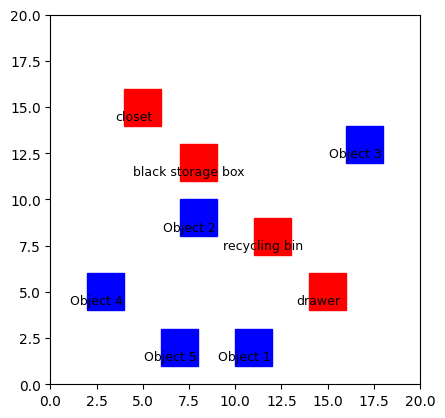

In [16]:
fig = plt.figure(123)
ax = fig.add_subplot(111, aspect='equal')
for i, obs in enumerate(object_obstacles):
    ax.add_patch(
    patches.Rectangle(
    obs[0],
    obs[1][0]-obs[0][0],
    obs[1][1]-obs[0][1], color='blue'))
    ax.annotate(f"Object {i+1}", xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                ha='center', va='center', fontsize=9, color='black')
for i, obs in enumerate(recept_obstacles):
    ax.add_patch(
    patches.Rectangle(
    obs[0],
    obs[1][0]-obs[0][0],
    obs[1][1]-obs[0][1], color='red'))
    ax.annotate(recept_text[i], xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                ha='center', va='center', fontsize=9, color='black')
ax.set(xlim=(0, width), ylim=(0, height))

line, = ax.plot([], [], marker='o', linestyle='-', color='g')

data = FINAL_PATH

def init():
    line.set_data([], [])
    return line,

# Function to update the plot for each frame
idx1 = 0
idx2 = 0
def update(frame):
    global idx1, idx2, line
    if idx1 + 1 < len(PATH_STATUS):
        if PATH_STATUS[idx1] == 1 and PATH_STATUS[idx1 + 1] == 0:
            ax.set_title("Going to object for picking")
        elif PATH_STATUS[idx1] == 1 and PATH_STATUS[idx1 + 1] == 1:
            ax.set_title("Going to object for tossing")
        else:
            ax.set_title("Going to receptacle")
    else:
        if PATH_STATUS[idx1] == 1:
            ax.set_title("Going to object for tossing")
        else:
            ax.set_title("Going to receptacle")
    if frame in UPDATE_PLOT_IDX:
        if PATH_STATUS[idx1] == 1:
            ax.clear()
            obs_remove = object_obstacles_copy[OBJECT_IDX[idx2]]
            object_obstacles.remove(obs_remove)
            idx2 += 1
            for obs in object_obstacles:
                obs_idx = object_obstacles_copy.index(obs)
                ax.add_patch(
                patches.Rectangle(
                obs[0],
                obs[1][0]-obs[0][0],
                obs[1][1]-obs[0][1], color='blue'))
                ax.annotate(f"Object {obs_idx+1}", xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            ha='center', va='center', fontsize=9, color='black')
            for i, obs in enumerate(recept_obstacles):
                ax.add_patch(
                patches.Rectangle(
                obs[0],
                obs[1][0]-obs[0][0],
                obs[1][1]-obs[0][1], color='red'))
                ax.annotate(recept_text[i], xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            ha='center', va='center', fontsize=9, color='black')
            ax.set(xlim=(0, width), ylim=(0, height))
            line, = ax.plot([], [], marker='o', linestyle='-', color='g')
        idx1 += 1
    x, y = data[frame]
    line.set_data(x, y)
    return line,

animation = FuncAnimation(fig, update, frames=len(data), init_func=init, blit=True)

### Comment this out for viewing animation in this notebook
## writervideo = matplotlib.animation.FFMpegWriter(fps=5) 
## animation.save('MDP2.mp4', writer=writervideo)
###

plt.show()

In [17]:
for obj in object_mappings:
    print(f"{obj['object']} - Primitive: {obj['primitive']}, Receptacle: {obj['receptacle']}")

Object 1 - Primitive: pick and toss, Receptacle: black storage box
Object 2 - Primitive: pick and toss, Receptacle: drawer
Object 3 - Primitive: pick and toss, Receptacle: drawer
Object 4 - Primitive: pick and place, Receptacle: black storage box
Object 5 - Primitive: pick and place, Receptacle: black storage box


In [18]:
HTML(animation.to_jshtml())

C:\Users\abhyu\AppData\Local\Temp\ipykernel_13960\1658639240.py:77: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)


In [19]:
diff = np.diff(FINAL_PATH, axis=0)
total_dist = np.sum(np.linalg.norm(diff, axis=1))
v_des = 0.45
total_time = 2 * total_dist / v_des # Assuming it accelerates from rest, and then decelerated to rest

primitives = [d["primitive"] for d in object_mappings]
no_of_tosses = primitives.count("pick and toss")
no_of_pick_and_places = primitives.count("pick and place")

time_toss = 4.0
time_for_pick_or_place = 2.5
total_time += no_of_tosses * time_toss + no_of_pick_and_places * time_for_pick_or_place * 2
print("Total time:", total_time)

Total time: 250.69264054540312


## MDP Value Iteration

In [20]:
objects_data, obj_coords = mapping(object_mappings)
receptacle_coords = list(receptacle_location_map.values())
print(objects_data)
print(obj_coords)
print(receptacle_coords)

[[11, 2, 1, 3], [8, 9, 1, 0], [17, 13, 1, 0], [3, 5, 0, 3], [7, 2, 0, 3]]
[(11, 2), (8, 9), (17, 13), (3, 5), (7, 2)]
[(15, 5), (5, 15), (12, 8), (8, 12)]


In [21]:
grid_world = GridWorldMDP(objects_data, obj_coords, receptacle_coords, nT, grid_size=grid_size+1)
grid_world.value_iteration(num_iterations=3000)

64
Iteration: 0
Error: 100.0
Iteration: 1
Error: 90.0
Iteration: 2
Error: 81.0
Iteration: 3
Error: 72.89999999999999
Iteration: 4
Error: 65.60999999999999
Iteration: 5
Error: 59.04899999999999
Iteration: 6
Error: 53.14410000000001
Iteration: 7
Error: 47.829690000000014
Iteration: 8
Error: 43.04672100000002
Iteration: 9
Error: 38.74204890000003
Iteration: 10
Error: 34.867844010000056
Iteration: 11
Error: 31.38105960900006
Iteration: 12
Error: 28.242953648100055
Iteration: 13
Error: 25.418658283290057
Iteration: 14
Error: 22.87679245496105
Iteration: 15
Error: 20.589113209464955
Iteration: 16
Error: 18.530201888518455
Iteration: 17
Error: 16.677181699666605
Iteration: 18
Error: 15.009463529699943
Iteration: 19
Error: 13.508517176729953
Iteration: 20
Error: 12.157665459056972
Iteration: 21
Error: 10.941898913151277
Iteration: 22
Error: 9.847709021836152
Iteration: 23
Error: 8.862938119652526
Iteration: 24
Error: 7.97664430768728
Iteration: 25
Error: 7.178979876918561
Iteration: 26
Error: 

### Rollout

In [22]:
horizon = 200
init_state = (10, 10, list(np.ones(grid_world.n_objects, dtype=int)))
trajectory = [init_state]
returns = 0
terminal_obj_status = list(np.concatenate([np.zeros(grid_world.nT, dtype=int), -1*np.ones(grid_world.nP, dtype=int)]))
for i in range(horizon):
    state = trajectory[i]
    action = grid_world.actions[grid_world.policy[state[0], state[1], grid_world.out.index(state[2])]]
    next_state = grid_world.transition(state, action)
    reward = grid_world.main_reward(state, action, next_state)
    returns += reward
    trajectory.append(next_state)
    if next_state[-1] == terminal_obj_status:
        print("Terminating Rollout!!!")
        break

Terminating Rollout!!!


In [23]:
print("Total reward accumulated:", returns)

Total reward accumulated: 399.6800000000002


In [24]:
POLICY_PATH = [(state[0], state[1]) for state in trajectory]
print(POLICY_PATH)

[(10, 10), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 14), (15, 13), (16, 12), (17, 11), (17, 10), (16, 9), (15, 8), (14, 7), (13, 6), (12, 5), (11, 4), (10, 3), (9, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 11), (8, 10), (7, 9), (6, 8), (5, 7), (4, 6), (4, 7), (4, 8), (5, 9), (6, 10), (7, 11)]


### Animating rollout policy

In [25]:
width = grid_size
height = grid_size
objects = copy(objects_copy)
receptacles = list(receptacle_location_map.values())
object_vertices, object_obstacles = get_obstacles_and_vertices(objects)
recept_vertices, recept_obstacles = get_obstacles_and_vertices(receptacles)
object_obstacles_copy = copy(object_obstacles)
recept_text = list(receptacle_location_map.keys())

In [26]:
def find_difference(list1, list2):
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return i

In [27]:
POLICY_PATH_STATUS = []
POLICY_OBJECT_IDX = []
POLICY_UPDATE_PLOT_IDX = []
for i in range(len(trajectory)):
    if i < len(trajectory) - 1:
        status_vec = trajectory[i][-1]
        next_status_vec = trajectory[i + 1][-1]
        idx = find_difference(status_vec, next_status_vec)
        if idx is not None:
            POLICY_UPDATE_PLOT_IDX.append(i + 1)
            if status_vec[idx] == 1 and next_status_vec[idx] == 0:
                POLICY_PATH_STATUS.append(1)
                POLICY_OBJECT_IDX.append(idx)
            elif status_vec[idx] == 0 and next_status_vec[idx] == -1:
                POLICY_PATH_STATUS.append(0)
            else:
                pass

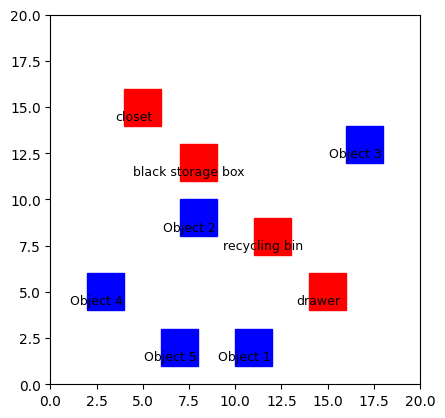

In [28]:
fig = plt.figure(123)
ax = fig.add_subplot(111, aspect='equal')
for i, obs in enumerate(object_obstacles):
    ax.add_patch(
    patches.Rectangle(
    obs[0],
    obs[1][0]-obs[0][0],
    obs[1][1]-obs[0][1], color='blue'))
    ax.annotate(f"Object {i+1}", xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                ha='center', va='center', fontsize=9, color='black')
for i, obs in enumerate(recept_obstacles):
    ax.add_patch(
    patches.Rectangle(
    obs[0],
    obs[1][0]-obs[0][0],
    obs[1][1]-obs[0][1], color='red'))
    ax.annotate(recept_text[i], xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                ha='center', va='center', fontsize=9, color='black')
ax.set(xlim=(0, width), ylim=(0, height))

line, = ax.plot([], [], marker='o', linestyle='-', color='g')

data = POLICY_PATH

def init():
    line.set_data([], [])
    return line,

# Function to update the plot for each frame
idx1 = 0
idx2 = 0
def update(frame):
    global idx1, idx2, line
    if idx1 + 1 < len(POLICY_PATH_STATUS):
        if POLICY_PATH_STATUS[idx1] == 1 and POLICY_PATH_STATUS[idx1 + 1] == 0:
            ax.set_title("Going to object for picking")
        elif POLICY_PATH_STATUS[idx1] == 1 and POLICY_PATH_STATUS[idx1 + 1] == 1:
            ax.set_title("Going to object for tossing")
        else:
            ax.set_title("Going to receptacle")
    else:
        if POLICY_PATH_STATUS[idx1] == 1:
            ax.set_title("Going to object for tossing")
        else:
            ax.set_title("Going to receptacle")
    if frame in POLICY_UPDATE_PLOT_IDX:
        if POLICY_PATH_STATUS[idx1] == 1:
            ax.clear()
            obs_remove = object_obstacles_copy[POLICY_OBJECT_IDX[idx2]]
            object_obstacles.remove(obs_remove)
            idx2 += 1
            for obs in object_obstacles:
                obs_idx = object_obstacles_copy.index(obs)
                ax.add_patch(
                patches.Rectangle(
                obs[0],
                obs[1][0]-obs[0][0],
                obs[1][1]-obs[0][1], color='blue'))
                ax.annotate(f"Object {obs_idx+1}", xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            ha='center', va='center', fontsize=9, color='black')
            for i, obs in enumerate(recept_obstacles):
                ax.add_patch(
                patches.Rectangle(
                obs[0],
                obs[1][0]-obs[0][0],
                obs[1][1]-obs[0][1], color='red'))
                ax.annotate(recept_text[i], xy=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            xytext=(obs[0][0] + 1 / 2, obs[0][1] + 1 / 2),
                            ha='center', va='center', fontsize=9, color='black')
            ax.set(xlim=(0, width), ylim=(0, height))
            line, = ax.plot([], [], marker='o', linestyle='-', color='g')
        idx1 += 1
    x, y = data[frame]
    line.set_data(x, y)
    return line,

animation = FuncAnimation(fig, update, frames=len(data), init_func=init, blit=True)

### Comment this out for viewing animation in this notebook
# writervideo = matplotlib.animation.FFMpegWriter(fps=5)
# animation.save('MDP.mp4', writer=writervideo) 
###

plt.show()

In [29]:
HTML(animation.to_jshtml())

C:\Users\abhyu\AppData\Local\Temp\ipykernel_13960\3242733880.py:77: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)


In [30]:
diff = np.diff(POLICY_PATH, axis=0)
total_dist = np.sum(np.linalg.norm(diff, axis=1))
v_des = 0.45
total_time = 2 * total_dist / v_des # Assuming it accelerates from rest, and then decelerated to rest

time_toss = 4.0
time_for_pick_or_place = 2.5
total_time += grid_world.nT * time_toss + grid_world.nP * time_for_pick_or_place * 2
print("Total time:", total_time)

Total time: 232.46817359701052
